# Introduction to Data Science, Project
---
## Prediction of Mechanical Properties of Steels


<br>

**Objective:** To select an optimal set of elemental features and machine learning algorithm for predicting the value of tensile strength of steel


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import time
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.core.arrays import categorical

import matplotlib.pyplot as plt
import matplotlib.cm as cm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from catboost import CatBoostRegressor

from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
from matminer.datasets import get_available_datasets, load_dataset

from tqdm.notebook import tqdm

---
## 1. Dataset

In [3]:
df = pd.read_csv('Steels_kaggle.csv')
df.head()

,Alloy code,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (°C),0.2% Proof Stress (MPa),Tensile Strength (MPa),Elongation (%),Reduction in Area (%)
0,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,27,342,490,30,71
1,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,100,338,454,27,72
2,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,200,337,465,23,69
3,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,300,346,495,21,70
4,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,400,316,489,26,79


In [4]:
df.shape

(915, 20)

### Dataset: Outliers

<AxesSubplot:>

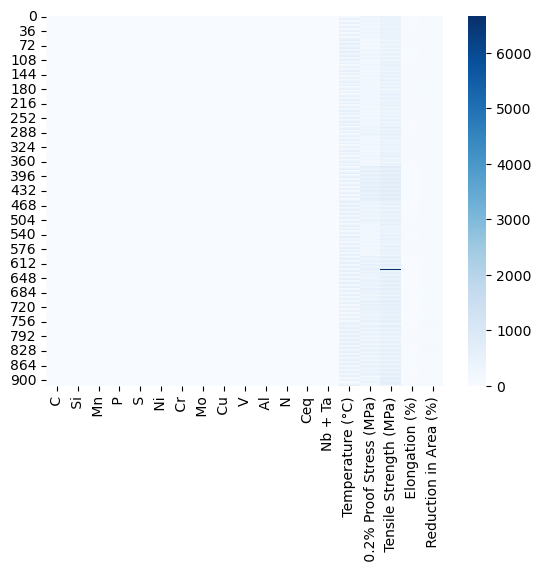

In [5]:
color = sns.color_palette("Blues", as_cmap=True)
alloy = 'C Si Mn P S Ni Cr Mo Cu V Al N'
elements = []

for item in df.keys():
    if item in alloy:
        elements.append(item)
        
cols = df.select_dtypes(include=[np.number]).columns 
sns.heatmap(df[cols], cmap=color)

<AxesSubplot:>

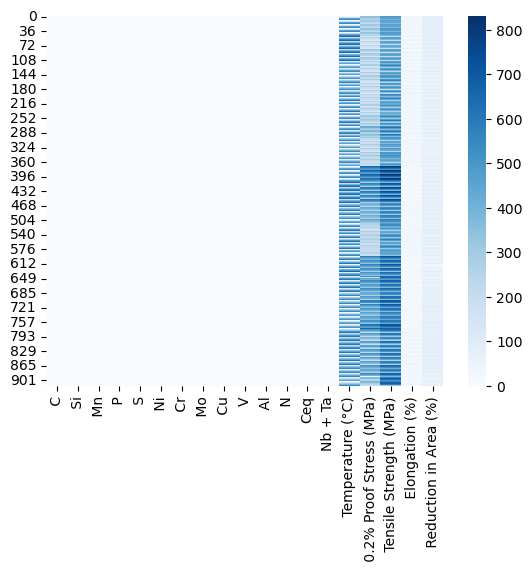

In [6]:
# discard values in the Tensile Strength column that are too large 
ind_outlier = df[df[' Tensile Strength (MPa)'] > 5000].index
df = df.drop(ind_outlier, axis=0)

sns.heatmap(df[cols], cmap=color)

---
## 2.1. Models Training (concentrations only)
<br>
Let's compare how much difference there is between models trained only on concatenations and models that take into account a large number of properties 

In [7]:
def plot_diff(ytrain, ytest):
    plt.figure(figsize=(8,6))
    plt.xlabel(u'$Tensile\ Strength_{true}$')
    plt.ylabel(u'$Tensile\ Strength_{predicted}$')
    RMSE = np.sqrt(mse(ytest, ytrain))
    
    plt.plot(ytrain, ytrain, c='black',linewidth=0.5)
    plt.scatter(ytrain, ytest, c='#00A9FF')
    plt.title('RMSE = {}'.format(round(RMSE, 3)))
    plt.legend(['True curve', 'Fit'])
    plt.grid()    
    plt.show()
    return

In [8]:
def CatBoostModel(X, y):
    model = CatBoostRegressor(verbose=0)
    model_cv = cross_validate(model, X, y, scoring=('neg_mean_squared_error','neg_mean_absolute_error'), 
                              cv=5, return_estimator=True)
    
    best_params = np.argmin(np.abs(model_cv['test_neg_mean_absolute_error']))
    best_model = model_cv['estimator'][best_params]
    return best_model

In [9]:
def RandomForestRegressorModel(X, y):
    param_grid = {
        'n_estimators': [10, 20, 50, 100, 200],   # Number of trees in the forest
         'max_depth'  : [5, 10, 15, 20, 25, 30],  # Maximum depth of the trees
    }

    grid_search = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    return best_model

In [10]:
def LinearRegressorModel(X, y):
    ridge = Ridge()
    alpha_values = np.logspace(-6, 3, 20)
    param_grid = {
    'alpha': alpha_values
    }
    grid_search = GridSearchCV(ridge, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_alphas = grid_search.best_params_
    best_ridge = Ridge(alpha=best_alphas['alpha'])
    best_ridge.fit(X_train, y_train)
    return best_ridge

### Concentrations: Pre-processing

In [11]:
# Remove columns that contain the same number in all rows:
df = df.loc[:, df.nunique() != 1]
print(f'Columns with constants: \t {len(df.loc[:, df.nunique() == 1].columns)}')

# Check if there are columns that contain NaN
columns_with_nan = df.columns[df.isnull().any()].tolist()
print(f'At least one NaN in column: \t {len(columns_with_nan)}')

# Categorical columns: One-hot encoding
categorical_columns = ['Alloy code']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

Columns with constants: 	 0
At least one NaN in column: 	 0


### Concentrations: Training

In [12]:
X = df[elements]
Y = df[' Tensile Strength (MPa)']

X.head()

,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N
0,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066
1,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066
2,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066
3,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066
4,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

#### Linear Regression

In [14]:
model_LR_c = LinearRegressorModel(X_train, y_train)

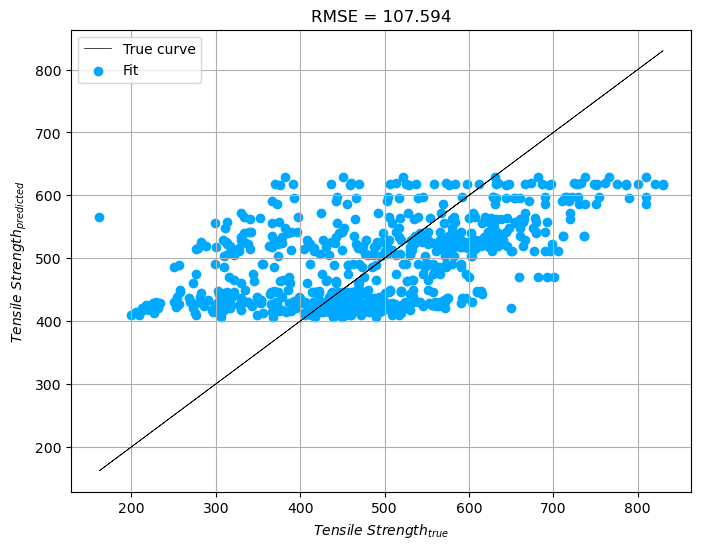

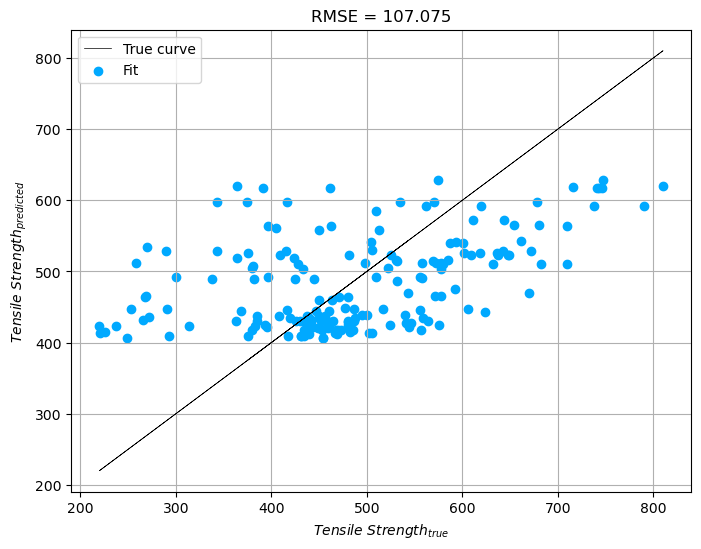

Test R^2: 0.20917136662216496


In [15]:
ypred_train = model_LR_c.predict(X_train)
ypred_test  = model_LR_c.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

#### Random Forest Regressor

In [16]:
model_RFR_c = RandomForestRegressorModel(X_train, y_train)

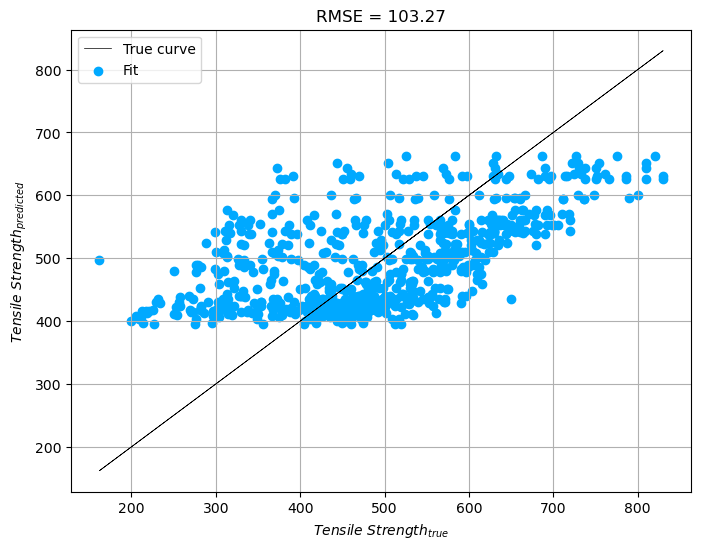

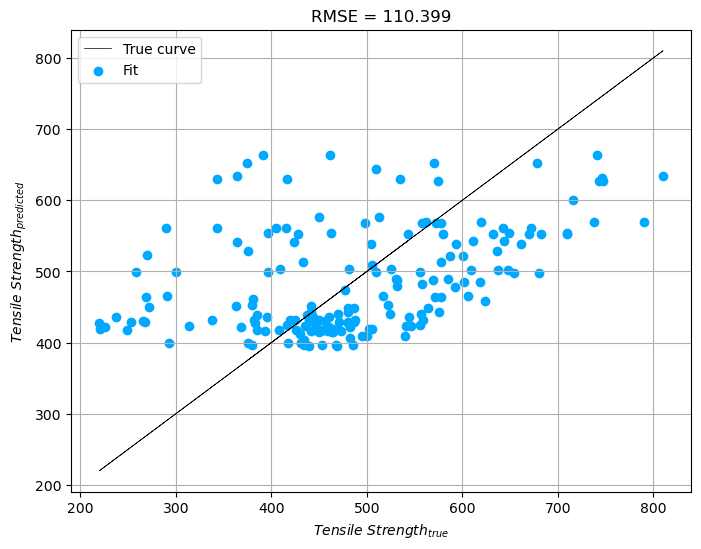

Test R^2: 0.1593045200783202


In [17]:
ypred_train = model_RFR_c.predict(X_train)
ypred_test  = model_RFR_c.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

#### Catboost

In [18]:
model_CB_c = CatBoostModel(X_train, y_train)

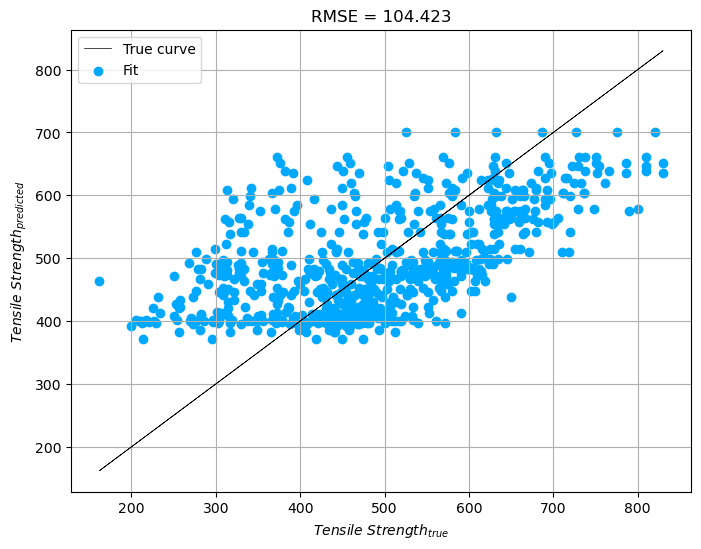

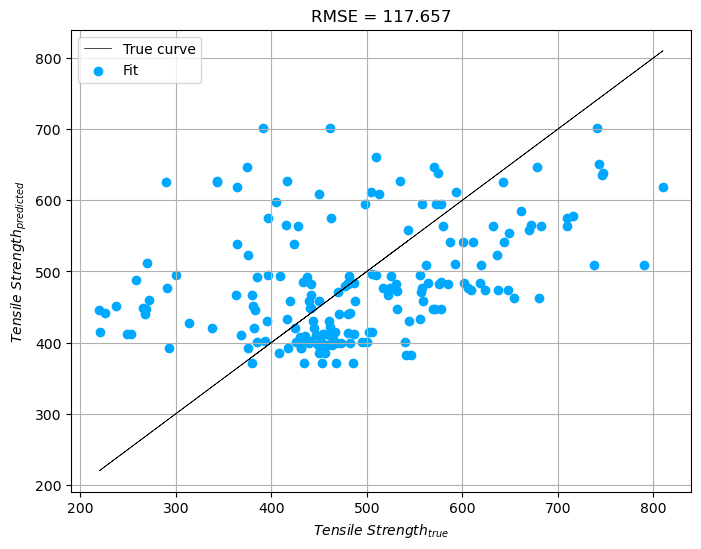

Test R^2: 0.045127688341171646


In [19]:
ypred_train = model_CB_c.predict(X_train)
ypred_test  = model_CB_c.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

---
## 2.2. Models Training (original dataset)
<br>
In the previous paragraph, we discarded all the data from the table to check the accuracy of the composition-property model. It turned out that the model is quite misleading. Now let's train the model on the entire original dataset

### Original Dataset: Pre-processing

In [20]:
df = pd.read_csv('Steels_kaggle.csv')
ind_outlier = df[df[' Tensile Strength (MPa)'] > 5000].index
df = df.drop(ind_outlier, axis=0)


# Remove columns that contain the same number in all rows:
df = df.loc[:, df.nunique() != 1]
print(f'Columns with constants: \t {len(df.loc[:, df.nunique() == 1].columns)}')

# Check if there are columns that contain NaN
columns_with_nan = df.columns[df.isnull().any()].tolist()
print(f'At least one NaN in column: \t {len(columns_with_nan)}')

# Categorical columns: One-hot encoding
categorical_columns = ['Alloy code']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

df.head()

Columns with constants: 	 0
At least one NaN in column: 	 0


,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (°C),0.2% Proof Stress (MPa),Tensile Strength (MPa),Elongation (%),Reduction in Area (%),Alloy code_CAB,Alloy code_CAC,Alloy code_CAG,Alloy code_CAH,Alloy code_CAJ,Alloy code_CAL,Alloy code_CAM,Alloy code_CAN,Alloy code_CCA,Alloy code_CCB,Alloy code_CaC,Alloy code_CaD,Alloy code_CaE,Alloy code_CaF,Alloy code_CaG,Alloy code_CaH,Alloy code_CaM,Alloy code_CaN,Alloy code_CbA,Alloy code_CbB,Alloy code_CbC,Alloy code_CbD,Alloy code_CbE,Alloy code_CbF,Alloy code_CbG,Alloy code_CbH,Alloy code_CbJ,Alloy code_CbL,Alloy code_CbM,Alloy code_CbN,Alloy code_CbR,Alloy code_CbS,Alloy code_CbT,Alloy code_CbU,Alloy code_CbV,Alloy code_CbW,Alloy code_CbX,Alloy code_CbY,Alloy code_CbZ,Alloy code_LAA,Alloy code_LAB,Alloy code_LAC,Alloy code_LAD,Alloy code_LAE,Alloy code_LAF,Alloy code_LAG,Alloy code_LAH,Alloy code_LAJ,Alloy code_LAL,Alloy code_LAM,Alloy code_LAN,Alloy code_LaA,Alloy code_LaB,Alloy code_LaD,Alloy code_LaE,Alloy code_LaF,Alloy code_MBB,Alloy code_MBC,Alloy code_MBD,Alloy code_MBE,Alloy code_MBF,Alloy code_MBG,Alloy code_MBH,Alloy code_MBJ,Alloy code_MBL,Alloy code_MBM,Alloy code_MBN,Alloy code_MFA,Alloy code_MFB,Alloy code_MFD,Alloy code_MFE,Alloy code_MFF,Alloy code_MFG,Alloy code_MFH,Alloy code_MFL,Alloy code_MFM,Alloy code_VaA,Alloy code_VaB,Alloy code_VaC,Alloy code_VaD,Alloy code_VaE,Alloy code_VaG,Alloy code_VaH,Alloy code_VaR,Alloy code_Vaj,Alloy code_VbA,Alloy code_VbB,Alloy code_VbD,Alloy code_VbF,Alloy code_VbG,Alloy code_VbH,Alloy code_VbJ,Alloy code_VbM,Alloy code_VbN
0,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,27,342,490,30,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,100,338,454,27,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,200,337,465,23,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,300,346,495,21,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,400,316,489,26,79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Original Dataset: Training

In [21]:
X = df.drop(' Tensile Strength (MPa)', inplace=False, axis=1)
Y = df[' Tensile Strength (MPa)']

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.20, random_state=42)

integer_columns = [column for column in X.columns if set(X[column]) != {0, 1}]

scaler = StandardScaler()
X_train[integer_columns] = scaler.fit_transform(X_train[integer_columns])
X_test[integer_columns]  = scaler.transform(X_test[integer_columns])

#### Linear Regression

In [22]:
model_LR_orig = LinearRegressorModel(X_train, y_train)

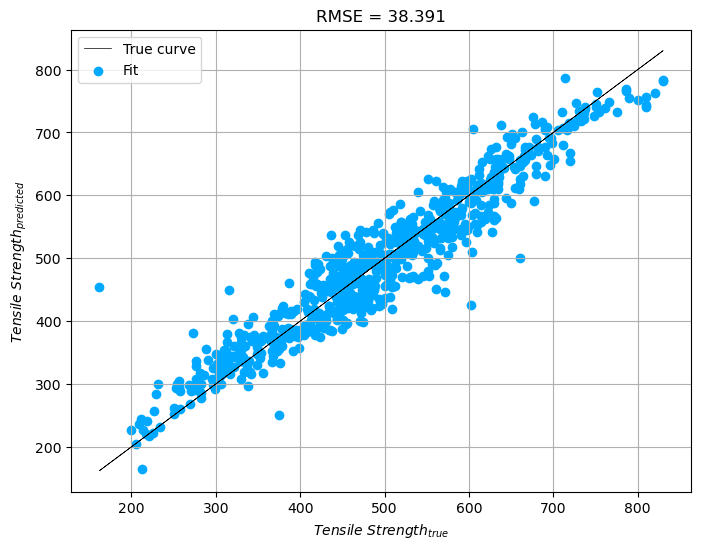

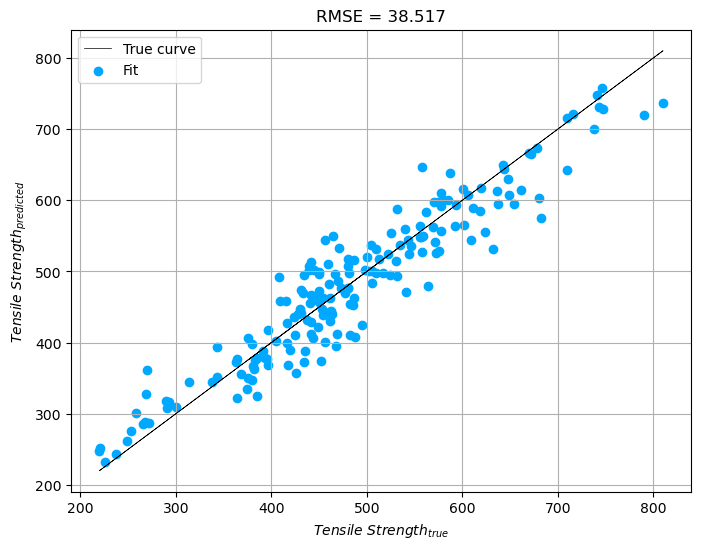

Test R^2: 0.897665884441961


In [23]:
ypred_train = model_LR_orig.predict(X_train)
ypred_test  = model_LR_orig.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

#### Random Forest Regressor

In [24]:
model_RFR_orig = RandomForestRegressorModel(X_train, y_train)

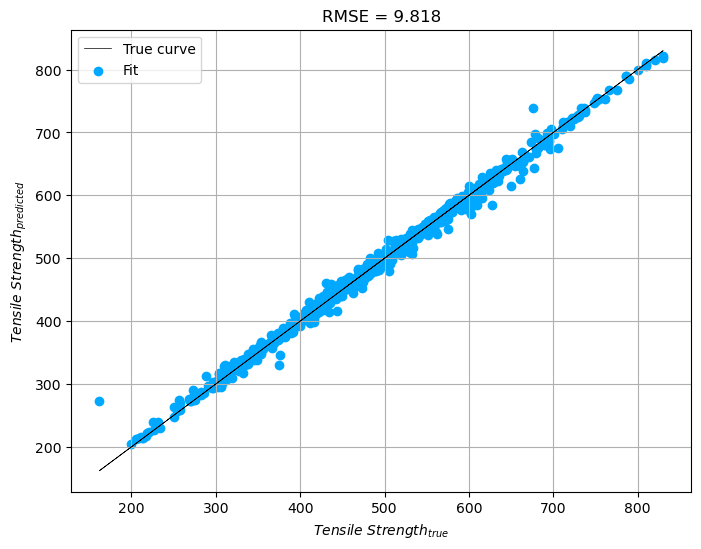

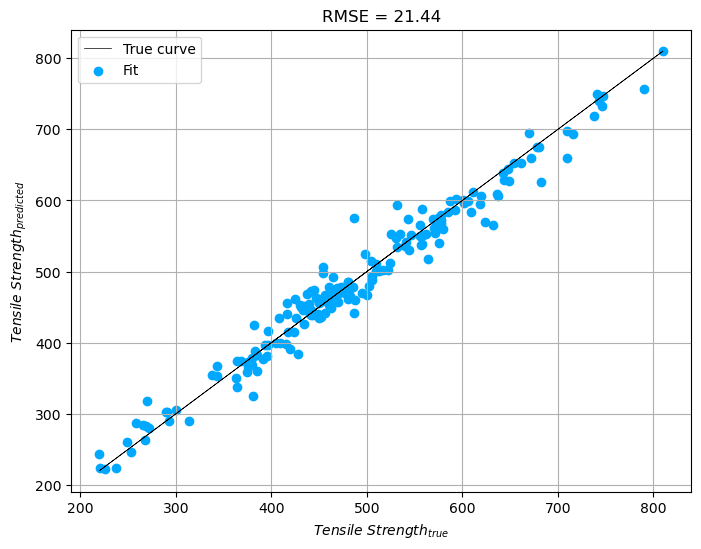

Test R^2: 0.9682927951710693


In [25]:
ypred_train = model_RFR_orig.predict(X_train)
ypred_test  = model_RFR_orig.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

#### Catboost

In [26]:
model_CB_orig = CatBoostModel(X_train, y_train)

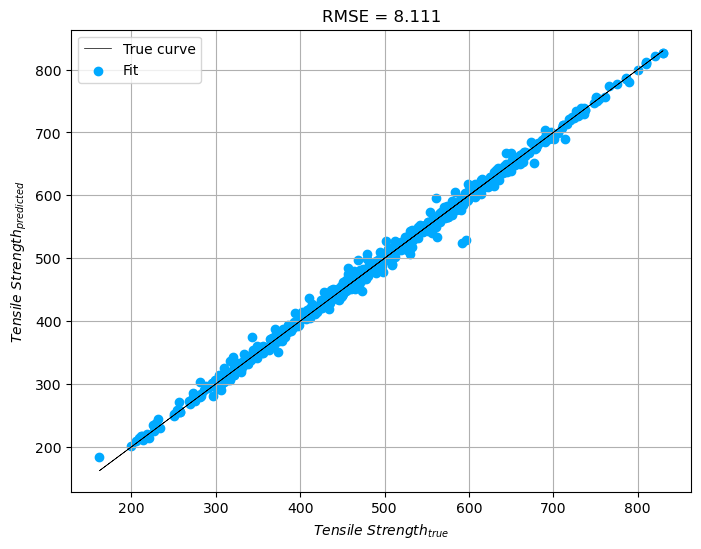

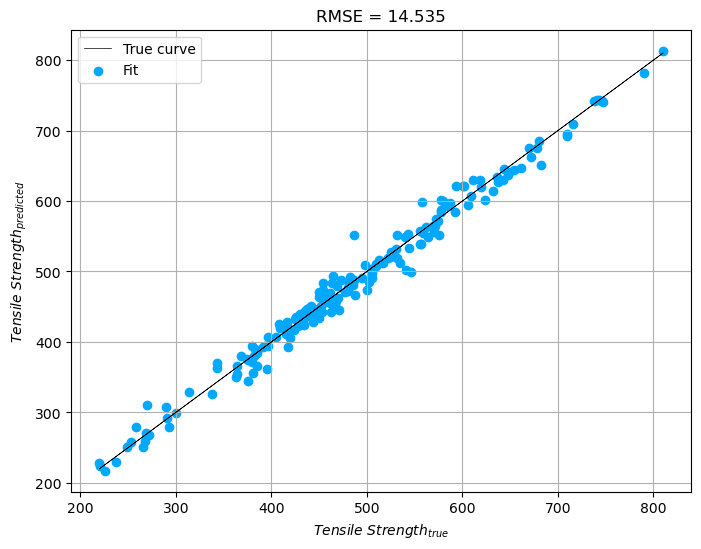

Test R^2: 0.9854265371676159


In [27]:
ypred_train = model_CB_orig.predict(X_train)
ypred_test  = model_CB_orig.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

---
## 2.3. Models Training (+Magpie features)
<br>
To expand our features, let's choose the magpie library -- a database with physical properties of steels calculated experimentally and theoretically 

### Magpie: Pre-processing
<br>
Add the "formula" row to the table to further convert it to composition and use the Magpie database methods

In [28]:
strings  = []
for i in df[elements[0]].index:
    string = ''
    for elem in elements:
        string += elem.replace(' ', '')
        string += str(df[elem][i])
    strings.append(string)
    
df['formula'] = strings
df.head()

,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (°C),0.2% Proof Stress (MPa),Tensile Strength (MPa),Elongation (%),Reduction in Area (%),Alloy code_CAB,Alloy code_CAC,Alloy code_CAG,Alloy code_CAH,Alloy code_CAJ,Alloy code_CAL,Alloy code_CAM,Alloy code_CAN,Alloy code_CCA,Alloy code_CCB,Alloy code_CaC,Alloy code_CaD,Alloy code_CaE,Alloy code_CaF,Alloy code_CaG,Alloy code_CaH,Alloy code_CaM,Alloy code_CaN,Alloy code_CbA,Alloy code_CbB,Alloy code_CbC,Alloy code_CbD,Alloy code_CbE,Alloy code_CbF,Alloy code_CbG,Alloy code_CbH,Alloy code_CbJ,Alloy code_CbL,Alloy code_CbM,Alloy code_CbN,Alloy code_CbR,Alloy code_CbS,Alloy code_CbT,Alloy code_CbU,Alloy code_CbV,Alloy code_CbW,Alloy code_CbX,Alloy code_CbY,Alloy code_CbZ,Alloy code_LAA,Alloy code_LAB,Alloy code_LAC,Alloy code_LAD,Alloy code_LAE,Alloy code_LAF,Alloy code_LAG,Alloy code_LAH,Alloy code_LAJ,Alloy code_LAL,Alloy code_LAM,Alloy code_LAN,Alloy code_LaA,Alloy code_LaB,Alloy code_LaD,Alloy code_LaE,Alloy code_LaF,Alloy code_MBB,Alloy code_MBC,Alloy code_MBD,Alloy code_MBE,Alloy code_MBF,Alloy code_MBG,Alloy code_MBH,Alloy code_MBJ,Alloy code_MBL,Alloy code_MBM,Alloy code_MBN,Alloy code_MFA,Alloy code_MFB,Alloy code_MFD,Alloy code_MFE,Alloy code_MFF,Alloy code_MFG,Alloy code_MFH,Alloy code_MFL,Alloy code_MFM,Alloy code_VaA,Alloy code_VaB,Alloy code_VaC,Alloy code_VaD,Alloy code_VaE,Alloy code_VaG,Alloy code_VaH,Alloy code_VaR,Alloy code_Vaj,Alloy code_VbA,Alloy code_VbB,Alloy code_VbD,Alloy code_VbF,Alloy code_VbG,Alloy code_VbH,Alloy code_VbJ,Alloy code_VbM,Alloy code_VbN,formula
0,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,27,342,490,30,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,C0.12Si0.36Mn0.52P0.009S0.003Ni0.089Cr0.97Mo0....
1,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,100,338,454,27,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,C0.12Si0.36Mn0.52P0.009S0.003Ni0.089Cr0.97Mo0....
2,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,200,337,465,23,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,C0.12Si0.36Mn0.52P0.009S0.003Ni0.089Cr0.97Mo0....
3,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,300,346,495,21,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,C0.12Si0.36Mn0.52P0.009S0.003Ni0.089Cr0.97Mo0....
4,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,400,316,489,26,79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,C0.12Si0.36Mn0.52P0.009S0.003Ni0.089Cr0.97Mo0....


In [29]:
stc = StrToComposition()
df = stc.featurize_dataframe(df, 'formula')
df.head()

StrToComposition:   0%|          | 0/914 [00:00<?, ?it/s]

,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (°C),0.2% Proof Stress (MPa),Tensile Strength (MPa),Elongation (%),Reduction in Area (%),Alloy code_CAB,Alloy code_CAC,Alloy code_CAG,Alloy code_CAH,Alloy code_CAJ,Alloy code_CAL,Alloy code_CAM,Alloy code_CAN,Alloy code_CCA,Alloy code_CCB,Alloy code_CaC,Alloy code_CaD,Alloy code_CaE,Alloy code_CaF,Alloy code_CaG,Alloy code_CaH,Alloy code_CaM,Alloy code_CaN,Alloy code_CbA,Alloy code_CbB,Alloy code_CbC,Alloy code_CbD,Alloy code_CbE,Alloy code_CbF,Alloy code_CbG,Alloy code_CbH,Alloy code_CbJ,Alloy code_CbL,Alloy code_CbM,Alloy code_CbN,Alloy code_CbR,Alloy code_CbS,Alloy code_CbT,Alloy code_CbU,Alloy code_CbV,Alloy code_CbW,Alloy code_CbX,Alloy code_CbY,Alloy code_CbZ,Alloy code_LAA,Alloy code_LAB,Alloy code_LAC,Alloy code_LAD,Alloy code_LAE,Alloy code_LAF,Alloy code_LAG,Alloy code_LAH,Alloy code_LAJ,Alloy code_LAL,Alloy code_LAM,Alloy code_LAN,Alloy code_LaA,Alloy code_LaB,Alloy code_LaD,Alloy code_LaE,Alloy code_LaF,Alloy code_MBB,Alloy code_MBC,Alloy code_MBD,Alloy code_MBE,Alloy code_MBF,Alloy code_MBG,Alloy code_MBH,Alloy code_MBJ,Alloy code_MBL,Alloy code_MBM,Alloy code_MBN,Alloy code_MFA,Alloy code_MFB,Alloy code_MFD,Alloy code_MFE,Alloy code_MFF,Alloy code_MFG,Alloy code_MFH,Alloy code_MFL,Alloy code_MFM,Alloy code_VaA,Alloy code_VaB,Alloy code_VaC,Alloy code_VaD,Alloy code_VaE,Alloy code_VaG,Alloy code_VaH,Alloy code_VaR,Alloy code_Vaj,Alloy code_VbA,Alloy code_VbB,Alloy code_VbD,Alloy code_VbF,Alloy code_VbG,Alloy code_VbH,Alloy code_VbJ,Alloy code_VbM,Alloy code_VbN,formula,composition
0,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,27,342,490,30,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,C0.12Si0.36Mn0.52P0.009S0.003Ni0.089Cr0.97Mo0....,"(C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)"
1,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,100,338,454,27,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,C0.12Si0.36Mn0.52P0.009S0.003Ni0.089Cr0.97Mo0....,"(C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)"
2,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,200,337,465,23,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,C0.12Si0.36Mn0.52P0.009S0.003Ni0.089Cr0.97Mo0....,"(C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)"
3,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,300,346,495,21,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,C0.12Si0.36Mn0.52P0.009S0.003Ni0.089Cr0.97Mo0....,"(C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)"
4,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,400,316,489,26,79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,C0.12Si0.36Mn0.52P0.009S0.003Ni0.089Cr0.97Mo0....,"(C, Si, Mn, P, S, Ni, Cr, Mo, Cu, Al, N)"


In [30]:
magpie = ElementProperty.from_preset('magpie')
df_magpie = magpie.featurize_dataframe(df, ['composition'])

ElementProperty:   0%|          | 0/914 [00:00<?, ?it/s]

In [31]:
df_magpie.head()

,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (°C),0.2% Proof Stress (MPa),Tensile Strength (MPa),Elongation (%),Reduction in Area (%),Alloy code_CAB,Alloy code_CAC,Alloy code_CAG,Alloy code_CAH,Alloy code_CAJ,Alloy code_CAL,Alloy code_CAM,Alloy code_CAN,Alloy code_CCA,Alloy code_CCB,Alloy code_CaC,Alloy code_CaD,Alloy code_CaE,Alloy code_CaF,Alloy code_CaG,Alloy code_CaH,Alloy code_CaM,Alloy code_CaN,Alloy code_CbA,Alloy code_CbB,Alloy code_CbC,Alloy code_CbD,Alloy code_CbE,Alloy code_CbF,Alloy code_CbG,Alloy code_CbH,Alloy code_CbJ,Alloy code_CbL,Alloy code_CbM,Alloy code_CbN,Alloy code_CbR,Alloy code_CbS,Alloy code_CbT,Alloy code_CbU,Alloy code_CbV,Alloy code_CbW,Alloy code_CbX,Alloy code_CbY,Alloy code_CbZ,Alloy code_LAA,Alloy code_LAB,Alloy code_LAC,Alloy code_LAD,Alloy code_LAE,Alloy code_LAF,Alloy code_LAG,Alloy code_LAH,Alloy code_LAJ,Alloy code_LAL,Alloy code_LAM,Alloy code_LAN,Alloy code_LaA,Alloy code_LaB,Alloy code_LaD,Alloy code_LaE,Alloy code_LaF,Alloy code_MBB,Alloy code_MBC,Alloy code_MBD,Alloy code_MBE,Alloy code_MBF,Alloy code_MBG,Alloy code_MBH,Alloy code_MBJ,Alloy code_MBL,Alloy code_MBM,Alloy code_MBN,Alloy code_MFA,Alloy code_MFB,Alloy code_MFD,Alloy code_MFE,Alloy code_MFF,Alloy code_MFG,Alloy code_MFH,Alloy code_MFL,Alloy code_MFM,Alloy code_VaA,Alloy code_VaB,Alloy code_VaC,Alloy code_VaD,Alloy code_VaE,Alloy code_VaG,Alloy code_VaH,Alloy code_VaR,Alloy code_Vaj,Alloy code_VbA,Alloy code_VbB,Alloy code_VbD,Alloy code_VbF,Alloy code_VbG,Alloy code_VbH,Alloy code_VbJ,Alloy code_VbM,Alloy code_VbN,formula,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData minimum Column,MagpieData maximum Column,MagpieData range Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData minimum Row,MagpieData maximum Row,MagpieData range Row,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mode Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData range NsValence,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mode NsValence,MagpieData minimum NpValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mode NpValence,MagpieData minimum NdValence,MagpieData maximum NdValence,MagpieData range NdValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mode NdValence,MagpieData minimum NfValence,MagpieData maximum NfValence,MagpieData range NfValence,MagpieData mean NfValence,MagpieData avg_dev NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData minimum NsUnfilled,MagpieData maximum NsUnfilled,MagpieData range NsUnfilled,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mode NsUnfilled,MagpieData minimum NpUnfilled,MagpieData maximu

In [59]:
# Remove artificially created columns from the table
df = df_magpie.drop(['formula', 'composition'], axis=1)

# Remove columns that contain the same number in all rows:
df = df.loc[:, df.nunique() != 1]
print(f'Columns with constants: \t {len(df.loc[:, df.nunique() == 1].columns)}')

# Check if there are columns that contain NaN
columns_with_nan = df.columns[df.isnull().any()].tolist()
print(f'At least one NaN in column: \t {len(columns_with_nan)}')

# Categorical columns: One-hot encoding
categorical_columns = []
for column in df.columns:
    if len(set(df[column])) <= 3:
        categorical_columns += [column]
print(f'Categorical columns: \t\t {len(categorical_columns)}')

df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print(f'\nShape of dataset: {df.shape}')

Columns with constants: 	 0
At least one NaN in column: 	 0
Categorical columns: 		 125

Shape of dataset: (914, 192)


In [60]:
df.head()

,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Temperature (°C),0.2% Proof Stress (MPa),Tensile Strength (MPa),Elongation (%),Reduction in Area (%),MagpieData mean Number,MagpieData avg_dev Number,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mean NpUnfilled,MagpieData avg_dev NpUnfilled,MagpieData mean NdUnfilled,MagpieData avg_dev NdUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,Nb + Ta_0.0017,Alloy code_CAB_1,Alloy code_CAC_1,Alloy code_CAG_1,Alloy code_CAH_1,Alloy code_CAJ_1,Alloy code_CAL_1,Alloy code_CAM_1,Alloy code_CAN_1,Alloy code_CCA_1,Alloy code_CCB_1,Alloy code_CaC_1,Alloy code_CaD_1,Alloy code_CaE_1,Alloy code_CaF_1,Alloy code_CaG_1,Alloy code_CaH_1,Alloy code_CaM_1,Alloy code_CaN_1,Alloy code_CbA_1,Alloy code_CbB_1,Alloy code_CbC_1,Alloy code_CbD_1,Alloy code_CbE_1,Alloy code_CbF_1,Alloy code_CbG_1,Alloy code_CbH_1,Alloy code_CbJ_1,Alloy code_CbL_1,Alloy code_CbM_1,Alloy code_CbN_1,Alloy code_CbR_1,Alloy code_CbS_1,Alloy code_CbT_1,Alloy code_CbU_1,Alloy code_CbV_1,Alloy code_CbW_1,Alloy code_CbX_1,Alloy code_CbY_1,Alloy code_CbZ_1,Alloy code_LAA_1,Alloy code_LAB_1,Alloy code_LAC_1,Alloy code_LAD_1,Alloy code_LAE_1,Alloy code_LAF_1,Alloy code_LAG_1,Alloy code_LAH_1,Alloy code_LAJ_1,Alloy code_LAL_1,Alloy code_LAM_1,Alloy code_LAN_1,Alloy code_LaA_1,Alloy code_LaB_1,Alloy code_LaD_1,Alloy code_LaE_1,Alloy code_LaF_1,Alloy code_MBB_1,Alloy code_MBC_1,Alloy code_MBD_1,Alloy code_MBE_1,Alloy code_MBF_1,Alloy code_MBG_1,Alloy code_MBH_1,Alloy code_MBJ_1,Alloy code_MBL_1,Alloy code_MBM_1,Alloy code_MBN_1,Alloy code_MFA_1,Alloy code_MFB_1,Alloy code_MFD_1,Alloy code_MFE_1,Alloy code_MFF_1,Alloy code_MFG_1,Alloy code_MFH_1,Alloy code_MFL_1,Alloy code_MFM_1,Alloy code_VaA_1,Alloy code_VaB_1,Alloy code_VaC_1,Alloy code_VaD_1,Alloy code_VaE_1,Alloy code_VaG_1,Alloy code_VaH_1,Alloy code_VaR_1,Alloy code_Vaj_1,Alloy code_VbA_1,Alloy code_VbB_1,Alloy code_VbD_1,Alloy code_VbF_1,Alloy code_VbG_1,Alloy code_VbH_1,Alloy code_VbJ_1,Alloy code_VbM_1,Alloy code_VbN_1,MagpieData mode Number_25.0,MagpieData mode Number_42.0,MagpieData minimum MendeleevNumber_49.0,MagpieData minimum MendeleevNumber_50.0,MagpieData range MendeleevNumber_39.0,MagpieData range MendeleevNumber_42.0,MagpieData mode MendeleevNumber_50.0,MagpieData mode MendeleevNumber_52.0,MagpieData mode AtomicWeight_54.938045,MagpieData mode AtomicWeight_95.96,MagpieData mode MeltingT_2180.0,MagpieData mode MeltingT_2896.0,MagpieData minimum Column_6.0,MagpieData range Column_11.0,MagpieData mode Column_7.0,MagpieData mode Row_5.0,MagpieData mode CovalentRadius_154.0,MagpieData mode Electronegativity_1.66,MagpieData mode Electronegativity_2.16,MagpieData mode NsValence_2.0,MagpieData maximum NdValence_10.0,MagpieData range NdValence_10.0,MagpieData maximum NValence_11.0,MagpieData range NValence_8.0,MagpieData mode NValence_7.0,MagpieData mode NsUnfilled_1.0,MagpieData maximum NdUnfilled_7.0,MagpieData range NdUnfilled_7.0,MagpieData minimum NUnfilled_2.0,MagpieData maximum NUnfilled_7.0,MagpieData range NUnfilled_5.0,MagpieData range NUnfilled_6.0,MagpieData mode NUnfilled_6.0,MagpieData mode GSvo

<AxesSubplot:>

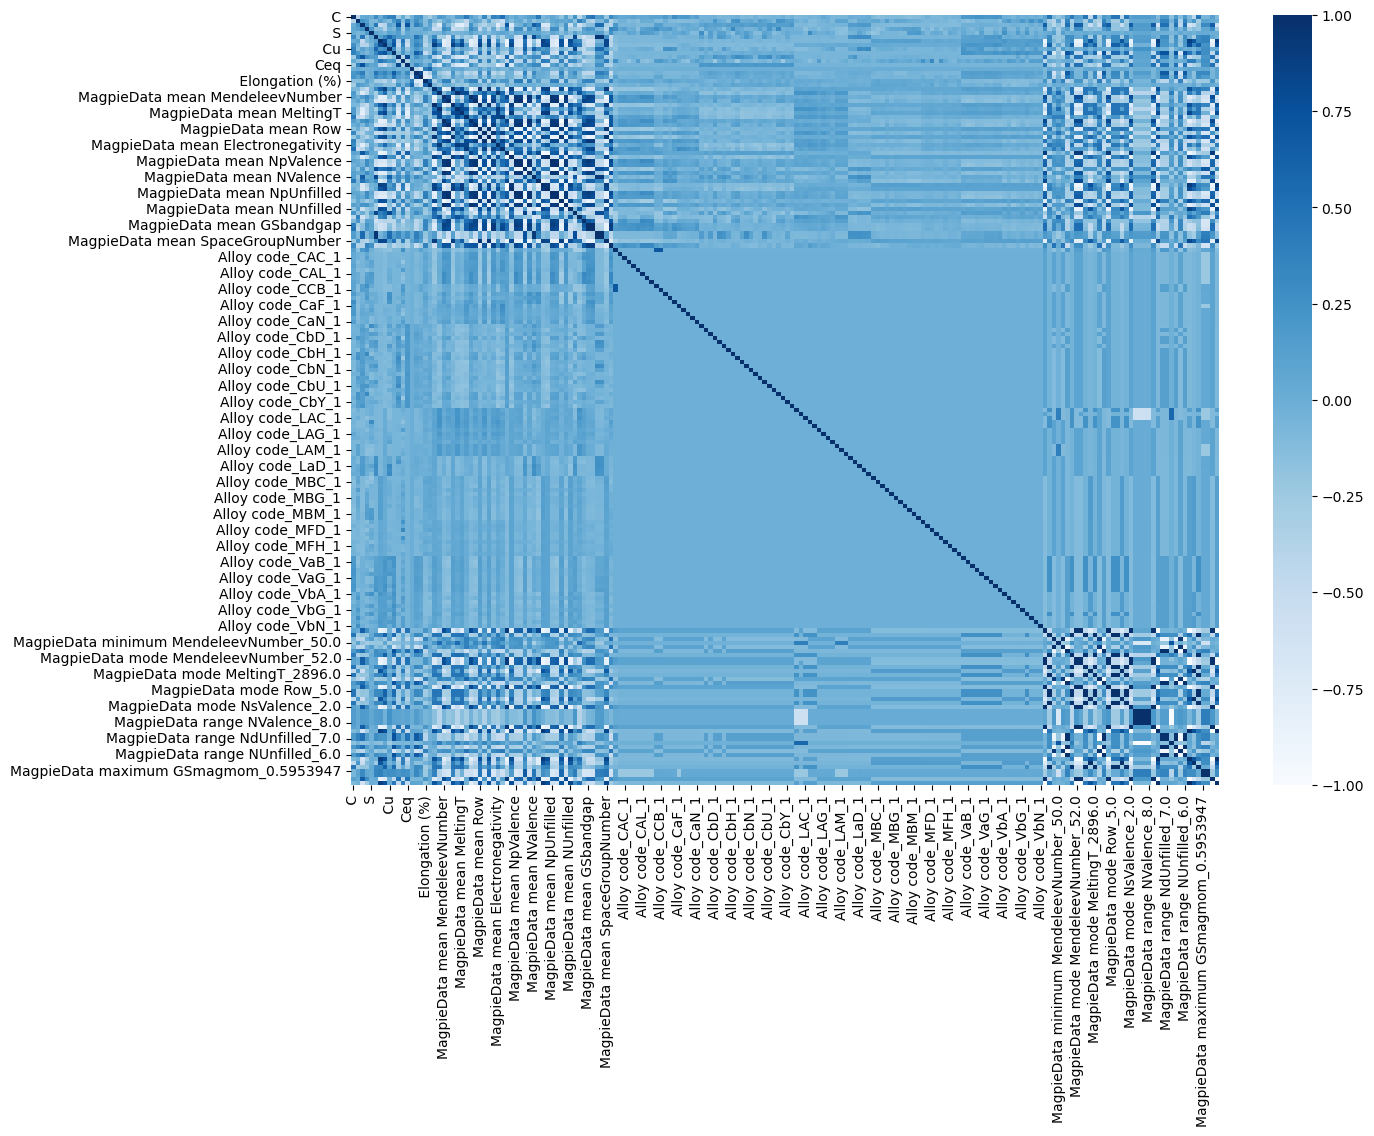

In [62]:
fig = plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap=color)

### Magpie: Training

In [35]:
X = df.drop(' Tensile Strength (MPa)', inplace=False, axis=1)
Y = df[' Tensile Strength (MPa)']

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.20, random_state=42)

integer_columns = [column for column in X.columns if set(X[column]) != {0, 1}]

scaler = StandardScaler()
X_train[integer_columns] = scaler.fit_transform(X_train[integer_columns])
X_test[integer_columns]  = scaler.transform(X_test[integer_columns])

#### Linear Regression

In [36]:
model_LR_mp = LinearRegressorModel(X_train, y_train)

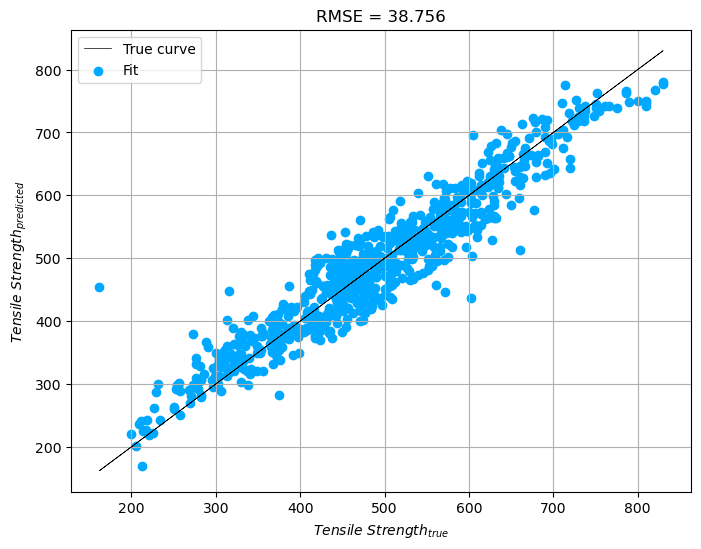

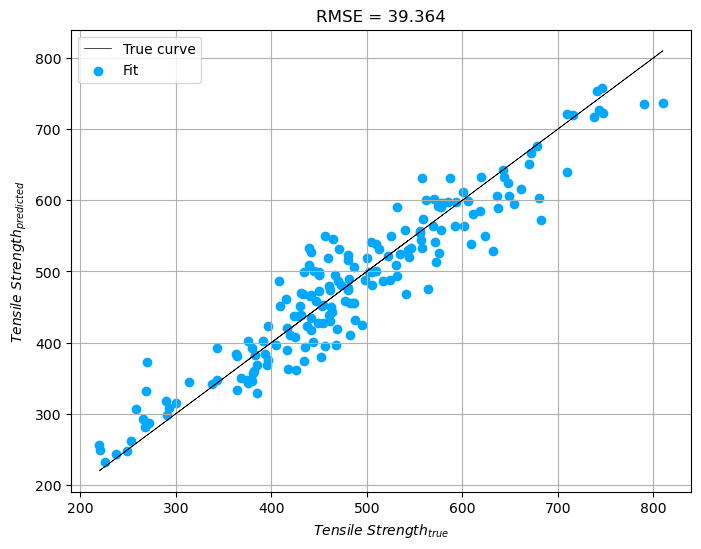

Test R^2: 0.8931165985330339


In [37]:
ypred_train = model_LR_mp.predict(X_train)
ypred_test  = model_LR_mp.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

#### Random Forest Regression

In [38]:
model_RFR_mp = RandomForestRegressorModel(X_train, y_train)

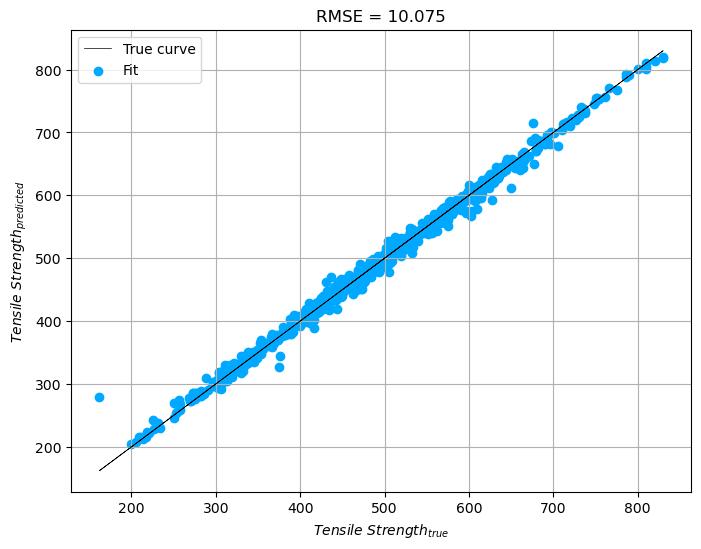

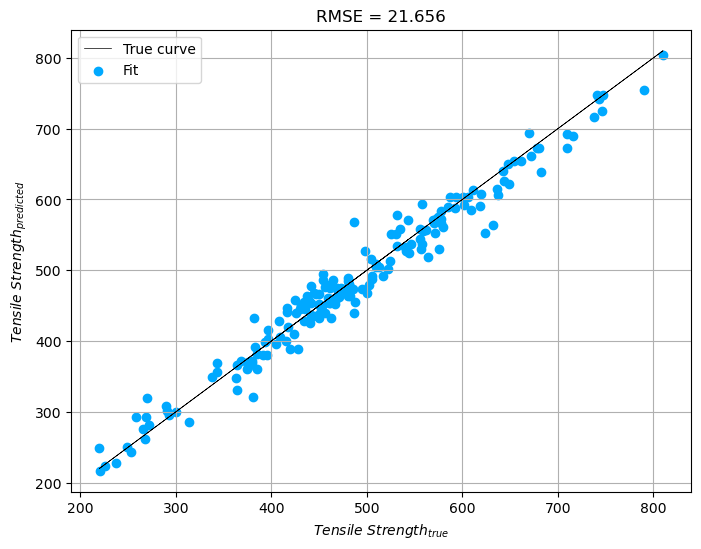

Test R^2: 0.9676520524331418


In [39]:
ypred_train = model_RFR_mp.predict(X_train)
ypred_test  = model_RFR_mp.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

#### Catboost

In [40]:
model_CB_mp = CatBoostModel(X_train, y_train)

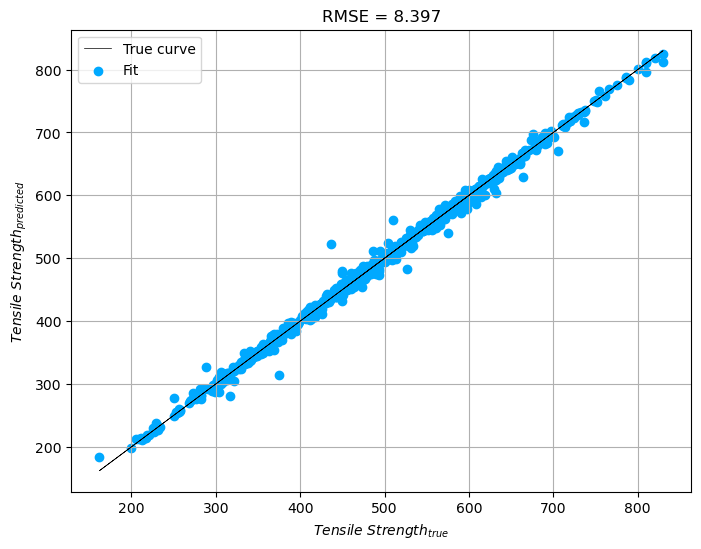

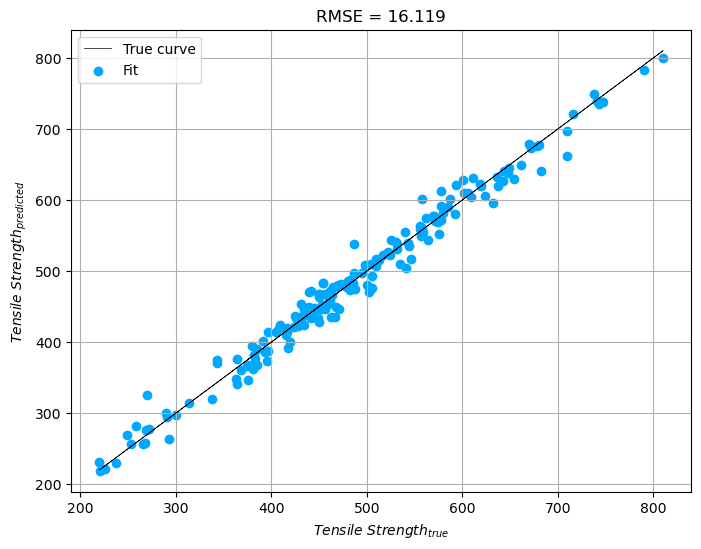

Test R^2: 0.9820775497968085


In [41]:
ypred_train = model_CB_mp.predict(X_train)
ypred_test  = model_CB_mp.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

---
## 2.4. Models Training (Magpie+Megnet features)
<br>
To expand our features even further, let's choose the megnet library -- designed to leverage graph neural networks to analyze materials' structural and compositional data to predict a variety of electronic and magnetic properties

### Magpie+Megnet: Pre-processing
<br>
Add the "formula" row to the table to further convert it to composition and use the Megnet database methods

In [42]:
megnet = ElementProperty.from_preset('megnet_el')
df_meg_mag = megnet.featurize_dataframe(df_magpie, ['composition'])

ElementProperty:   0%|          | 0/914 [00:00<?, ?it/s]

In [43]:
df_meg_mag.head()

,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (°C),0.2% Proof Stress (MPa),Tensile Strength (MPa),Elongation (%),Reduction in Area (%),Alloy code_CAB,Alloy code_CAC,Alloy code_CAG,Alloy code_CAH,Alloy code_CAJ,Alloy code_CAL,Alloy code_CAM,Alloy code_CAN,Alloy code_CCA,Alloy code_CCB,Alloy code_CaC,Alloy code_CaD,Alloy code_CaE,Alloy code_CaF,Alloy code_CaG,Alloy code_CaH,Alloy code_CaM,Alloy code_CaN,Alloy code_CbA,Alloy code_CbB,Alloy code_CbC,Alloy code_CbD,Alloy code_CbE,Alloy code_CbF,Alloy code_CbG,Alloy code_CbH,Alloy code_CbJ,Alloy code_CbL,Alloy code_CbM,Alloy code_CbN,Alloy code_CbR,Alloy code_CbS,Alloy code_CbT,Alloy code_CbU,Alloy code_CbV,Alloy code_CbW,Alloy code_CbX,Alloy code_CbY,Alloy code_CbZ,Alloy code_LAA,Alloy code_LAB,Alloy code_LAC,Alloy code_LAD,Alloy code_LAE,Alloy code_LAF,Alloy code_LAG,Alloy code_LAH,Alloy code_LAJ,Alloy code_LAL,Alloy code_LAM,Alloy code_LAN,Alloy code_LaA,Alloy code_LaB,Alloy code_LaD,Alloy code_LaE,Alloy code_LaF,Alloy code_MBB,Alloy code_MBC,Alloy code_MBD,Alloy code_MBE,Alloy code_MBF,Alloy code_MBG,Alloy code_MBH,Alloy code_MBJ,Alloy code_MBL,Alloy code_MBM,Alloy code_MBN,Alloy code_MFA,Alloy code_MFB,Alloy code_MFD,Alloy code_MFE,Alloy code_MFF,Alloy code_MFG,Alloy code_MFH,Alloy code_MFL,Alloy code_MFM,Alloy code_VaA,Alloy code_VaB,Alloy code_VaC,Alloy code_VaD,Alloy code_VaE,Alloy code_VaG,Alloy code_VaH,Alloy code_VaR,Alloy code_Vaj,Alloy code_VbA,Alloy code_VbB,Alloy code_VbD,Alloy code_VbF,Alloy code_VbG,Alloy code_VbH,Alloy code_VbJ,Alloy code_VbM,Alloy code_VbN,formula,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData minimum Column,MagpieData maximum Column,MagpieData range Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData minimum Row,MagpieData maximum Row,MagpieData range Row,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mode Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData range NsValence,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mode NsValence,MagpieData minimum NpValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mode NpValence,MagpieData minimum NdValence,MagpieData maximum NdValence,MagpieData range NdValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mode NdValence,MagpieData minimum NfValence,MagpieData maximum NfValence,MagpieData range NfValence,MagpieData mean NfValence,MagpieData avg_dev NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData minimum NsUnfilled,MagpieData maximum NsUnfilled,MagpieData range NsUnfilled,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mode NsUnfilled,MagpieData minimum NpUnfilled,MagpieData maximu

In [63]:
# Remove artificially created columns from the table
df = df_meg_mag.drop(['formula', 'composition'], axis=1)

# Remove columns that contain the same number in all rows:
df = df.loc[:, df.nunique() != 1]
print(f'Columns with constants: \t {len(df.loc[:, df.nunique() == 1].columns)}')

# Check if there are columns that contain NaN
columns_with_nan = df.columns[df.isnull().any()].tolist()
print(f'At least one NaN in column: \t {len(columns_with_nan)}')

# Categorical columns: One-hot encoding
categorical_columns = []
for column in df.columns:
    if len(set(df[column])) <= 3:
        categorical_columns += [column]
print(f'Categorical columns: \t\t {len(categorical_columns)}')

df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print(f'\nShape of dataset: {df.shape}')

Columns with constants: 	 0
At least one NaN in column: 	 0
Categorical columns: 		 131

Shape of dataset: (914, 230)


<AxesSubplot:>

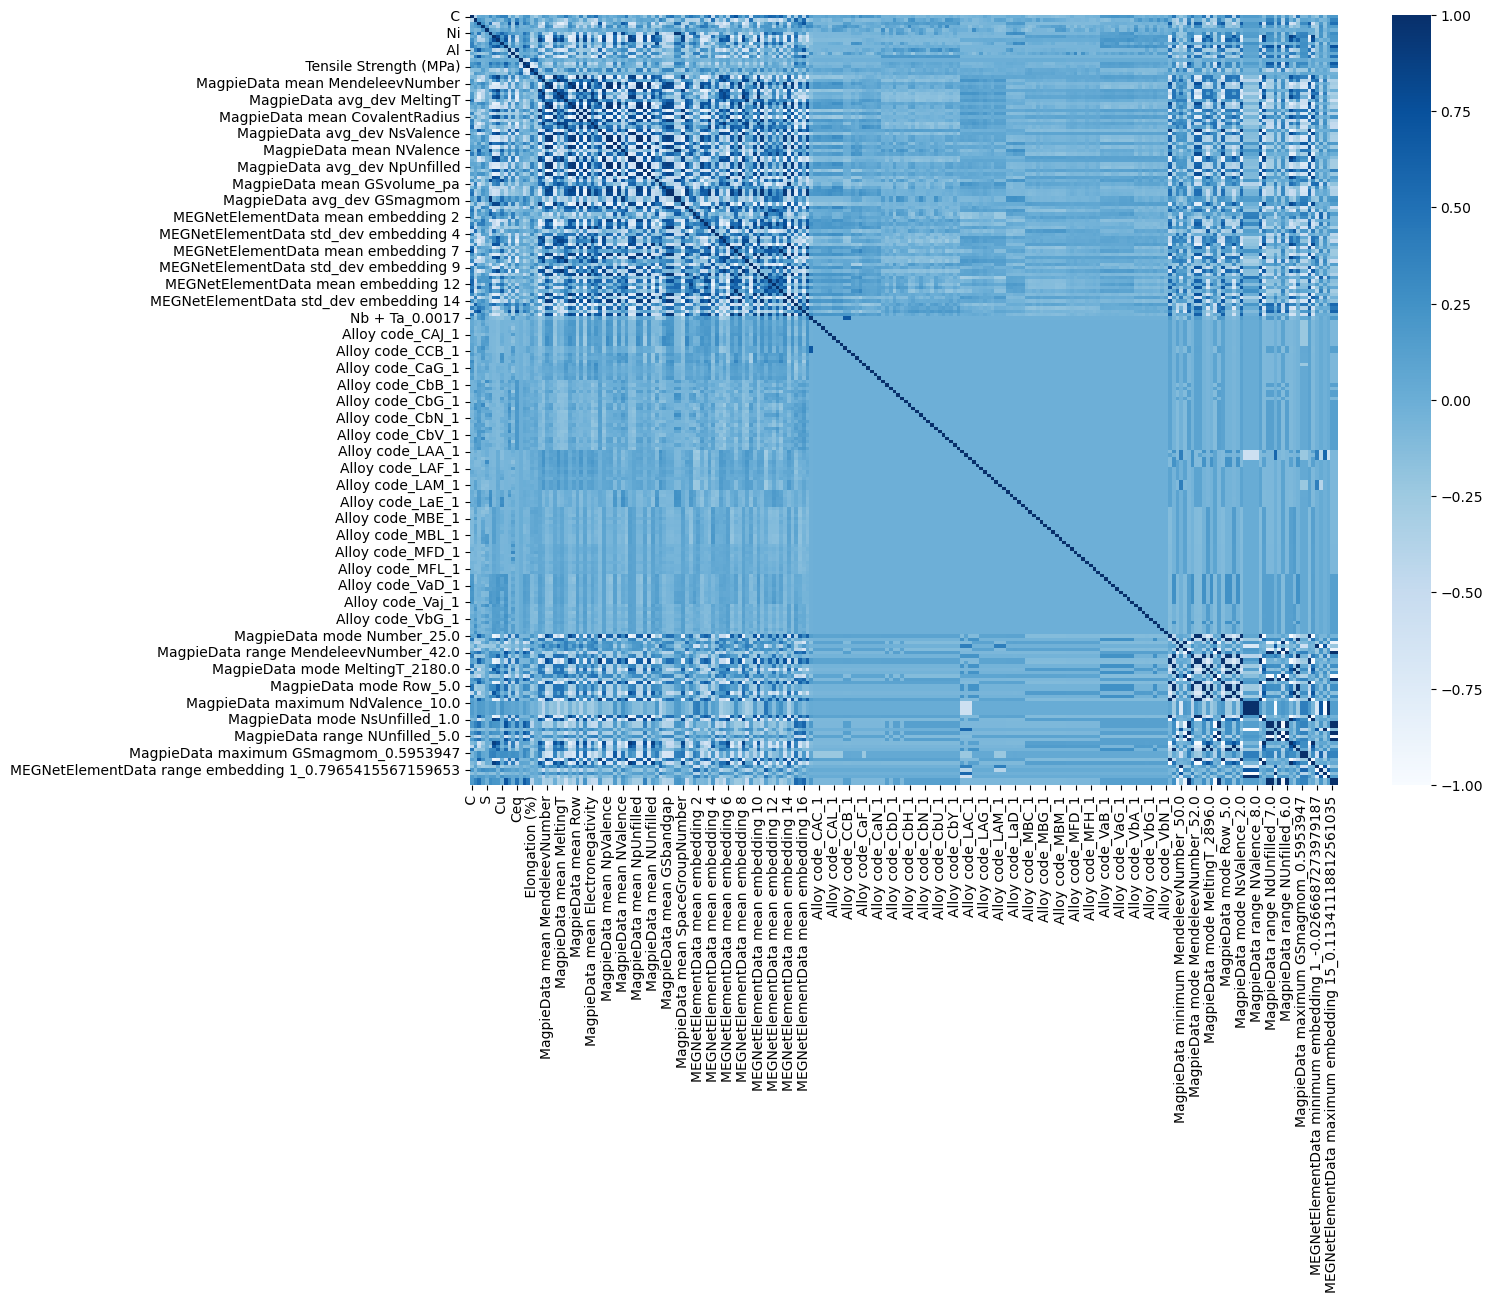

In [64]:
fig = plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap=color)

### Magpie+Megnet: Training

In [46]:
X = df.drop(' Tensile Strength (MPa)', inplace=False, axis=1)
Y = df[' Tensile Strength (MPa)']

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.20, random_state=42)

integer_columns = [column for column in X.columns if set(X[column]) != {0, 1}]

scaler = StandardScaler()
X_train[integer_columns] = scaler.fit_transform(X_train[integer_columns])
X_test[integer_columns]  = scaler.transform(X_test[integer_columns])

#### Linear Regression

In [47]:
model_LR_mp_mg = LinearRegressorModel(X_train, y_train)

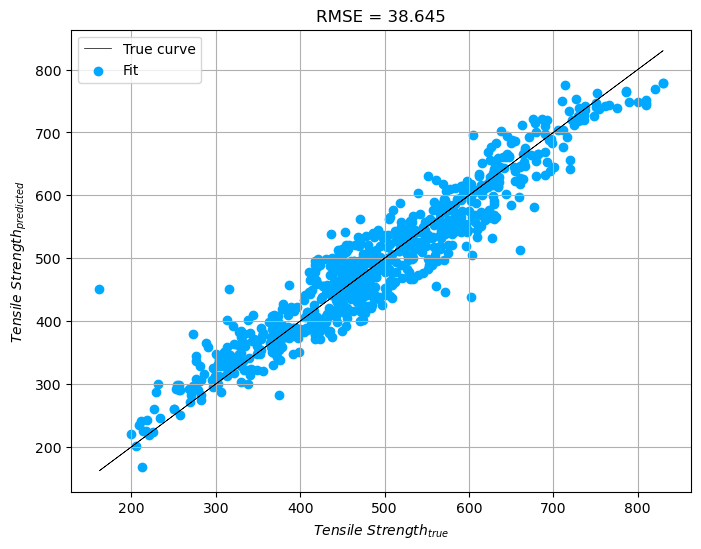

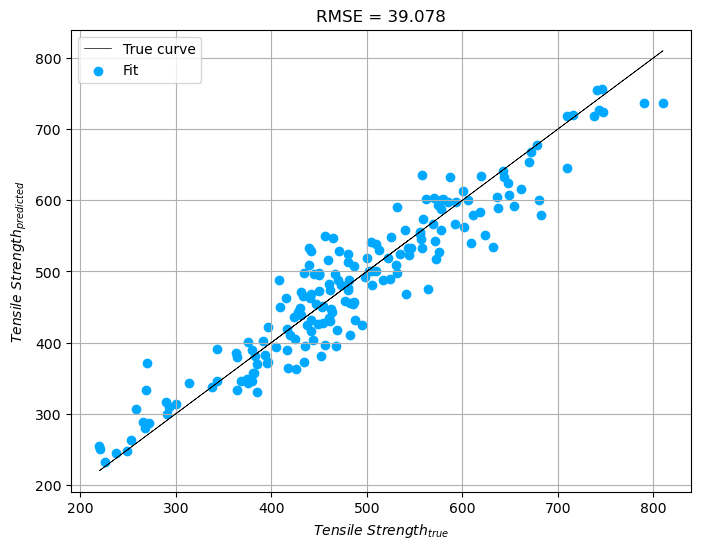

Test R^2: 0.8946670281025395


In [48]:
ypred_train = model_LR_mp_mg.predict(X_train)
ypred_test  = model_LR_mp_mg.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

#### Random Forest Regression

In [49]:
model_RFR_mp_mg = RandomForestRegressorModel(X_train, y_train)

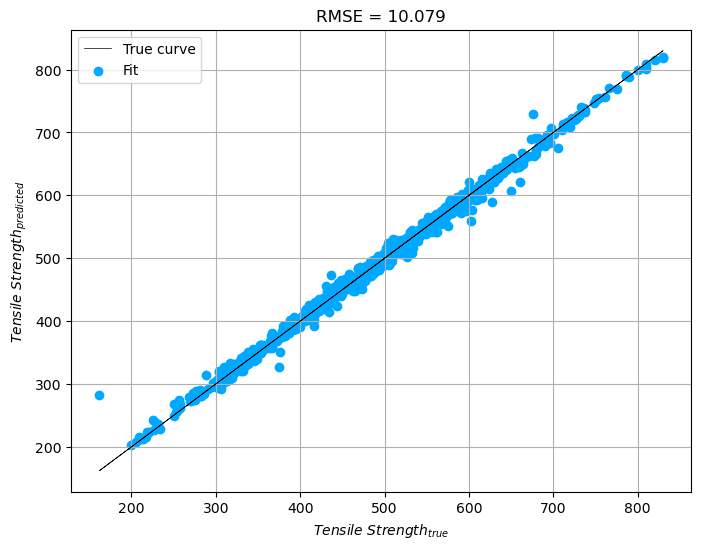

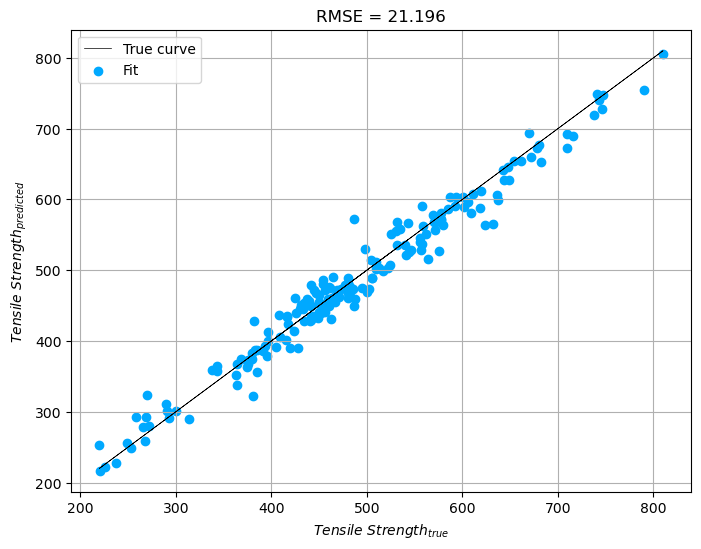

Test R^2: 0.9690116216160979


In [50]:
ypred_train = model_RFR_mp_mg.predict(X_train)
ypred_test  = model_RFR_mp_mg.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

#### Catboost

In [51]:
model_CB_mp_mg = CatBoostModel(X_train, y_train)

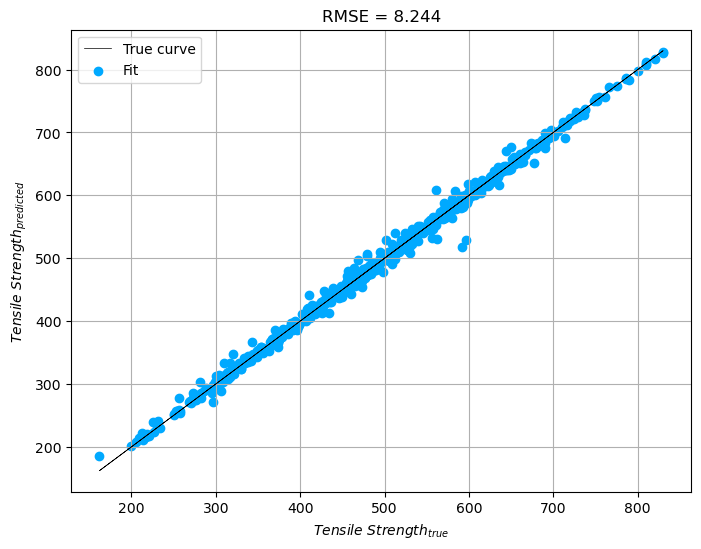

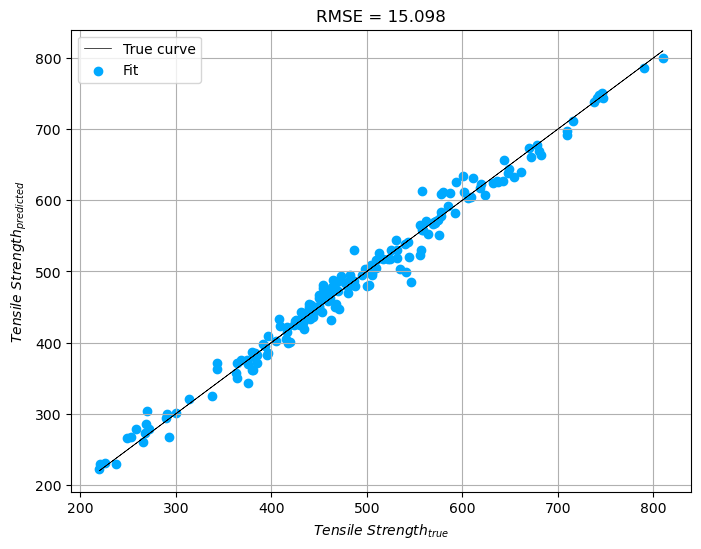

Test R^2: 0.9842763086059677


In [52]:
ypred_train = model_CB_mp_mg.predict(X_train)
ypred_test  = model_CB_mp_mg.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

---
## 3. Models Training (Magpie+Megnet: only most important features)
<br>
Train the best of the three models (Catboost) with selection of the most important features and see if the result improves

In [53]:
DATA = pd.DataFrame({'feature_importance': model_CB_mp_mg.get_feature_importance(), 
                     'feature_names': X.columns}).sort_values(by=['feature_importance'], 
                      ascending=False)

(array([225.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([ 0.        ,  3.81991039,  7.63982078, 11.45973116, 15.27964155,
        19.09955194, 22.91946233, 26.73937271, 30.5592831 , 34.37919349,
        38.19910388]),
 <BarContainer object of 10 artists>)

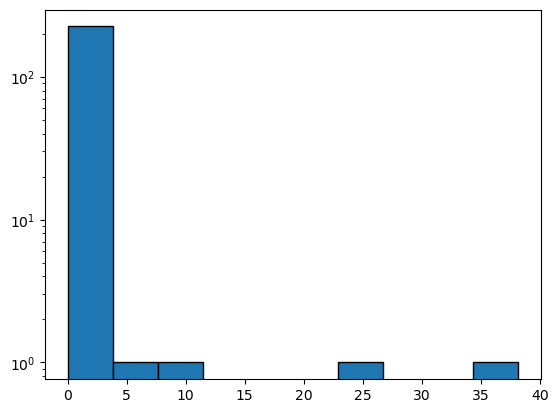

In [54]:
plt.hist(DATA['feature_importance'], bins=10, edgecolor='black', log=True)

In [55]:
# importance thresholds
importances = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 1, 5, 10] 

RMSE_trs = []
RMSE_tss = []
models = {}
dfs = {}
ts = []

print(f'importance \t N, features \t\t RMSE train \t\t RMSE test \t\t Exec Time')
for importance in importances:
    startpoint = time.time()
    df_new = df.copy()
    
    data_bad = DATA[DATA.feature_importance < importance]
    names = data_bad.drop(['feature_importance'], axis=1)
    names = np.array(names)
    
    for i in names:
        df_new.drop(i, axis=1, inplace=True)

    X = df_new.drop(' Tensile Strength (MPa)', inplace=False, axis=1)
    Y = df_new[' Tensile Strength (MPa)']

    X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.20, random_state=42)

    model = CatBoostModel(X_train, y_train)

    ypred_train = model.predict(X_train)
    ypred_test  = model.predict(X_test)

    RMSE_tr = np.sqrt(mse(y_train, ypred_train))
    RMSE_ts = np.sqrt(mse(y_test,  ypred_test))
    
    t = time.time() - startpoint
    print(f'{importance} \t\t {df_new.shape[1]} \t\t {RMSE_tr} \t\t {RMSE_ts} \t {t}')
    
    RMSE_trs.append(RMSE_tr)
    RMSE_tss.append(RMSE_ts)
    models[importance] = model
    dfs[importance] = df_new
    ts.append(t)

importance 	 N, features 		 RMSE train 		 RMSE test 		 Exec Time
0.1 		 78 		 8.307779958372032 		 15.3007137578423 	 46.022369146347046
0.2 		 51 		 7.730519486203243 		 14.876360218595348 	 32.18602418899536
0.3 		 31 		 8.519079602834688 		 16.62440320321818 	 22.353464603424072
0.4 		 17 		 7.8738772042673375 		 14.529036600242597 	 13.255486965179443
0.5 		 12 		 7.747209161501554 		 14.422729949748685 	 10.185240268707275
0.6 		 9 		 8.061068280479667 		 14.591235782556051 	 9.59945011138916
0.65 		 8 		 8.423838632006989 		 15.759287357425958 	 11.294089078903198
0.7 		 5 		 14.646867315993381 		 26.79135813707282 	 9.756108283996582
1 		 5 		 14.646867315993381 		 26.79135813707282 	 8.006228685379028
5 		 5 		 14.646867315993381 		 26.79135813707282 	 10.731266736984253
10 		 3 		 23.832891457289048 		 35.87928409029081 	 9.412081480026245


### Calculations for best model

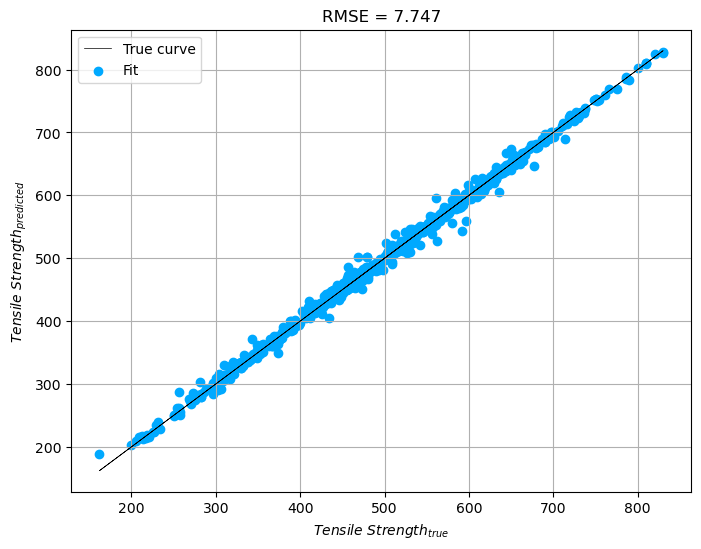

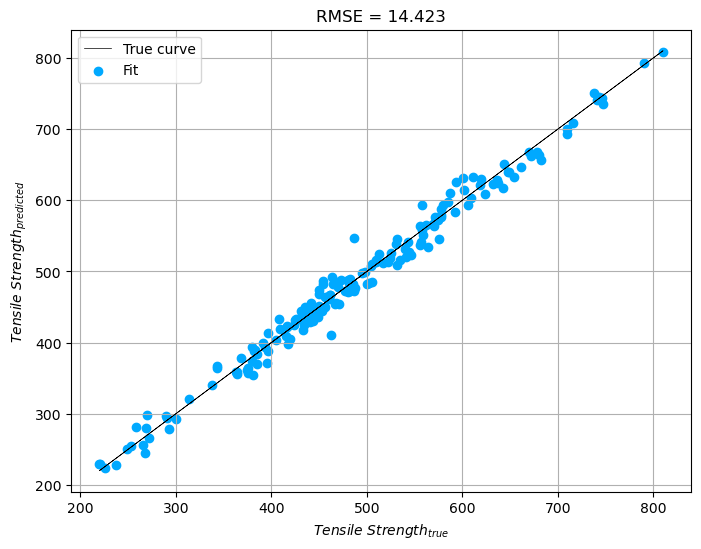

Test R^2: 0.9856516434990522


In [56]:
df_new = df.copy()
data_bad = DATA[DATA.feature_importance < 0.5]
names = data_bad.drop(['feature_importance'], axis=1)
names = np.array(names)

for i in names:
    df_new.drop(i, axis=1, inplace=True)

X = df_new.drop(' Tensile Strength (MPa)', inplace=False, axis=1)
Y = df_new[' Tensile Strength (MPa)']

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.20, random_state=42)
model = CatBoostModel(X_train, y_train)

ypred_train = model.predict(X_train)
ypred_test  = model.predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test,  ypred_test)

print("Test R^2:", r2_score(y_test, ypred_test))

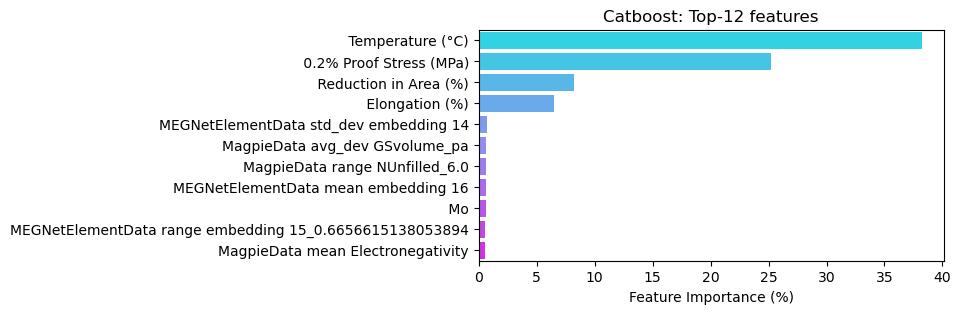

In [57]:
data_best = DATA[DATA.feature_importance > 0.5]

feat_df= pd.DataFrame({'feature': data_best.feature_names,'importance':data_best.feature_importance})
sorted_df=feat_df.sort_values('importance', ascending=False)

plt.figure(figsize=(6,3))
sns.barplot(x='importance', y='feature', data=sorted_df, palette='cool')
plt.title('Catboost: Top-12 features')
plt.xlabel('Feature Importance (%)')
plt.ylabel('')
plt.show()


<AxesSubplot:>

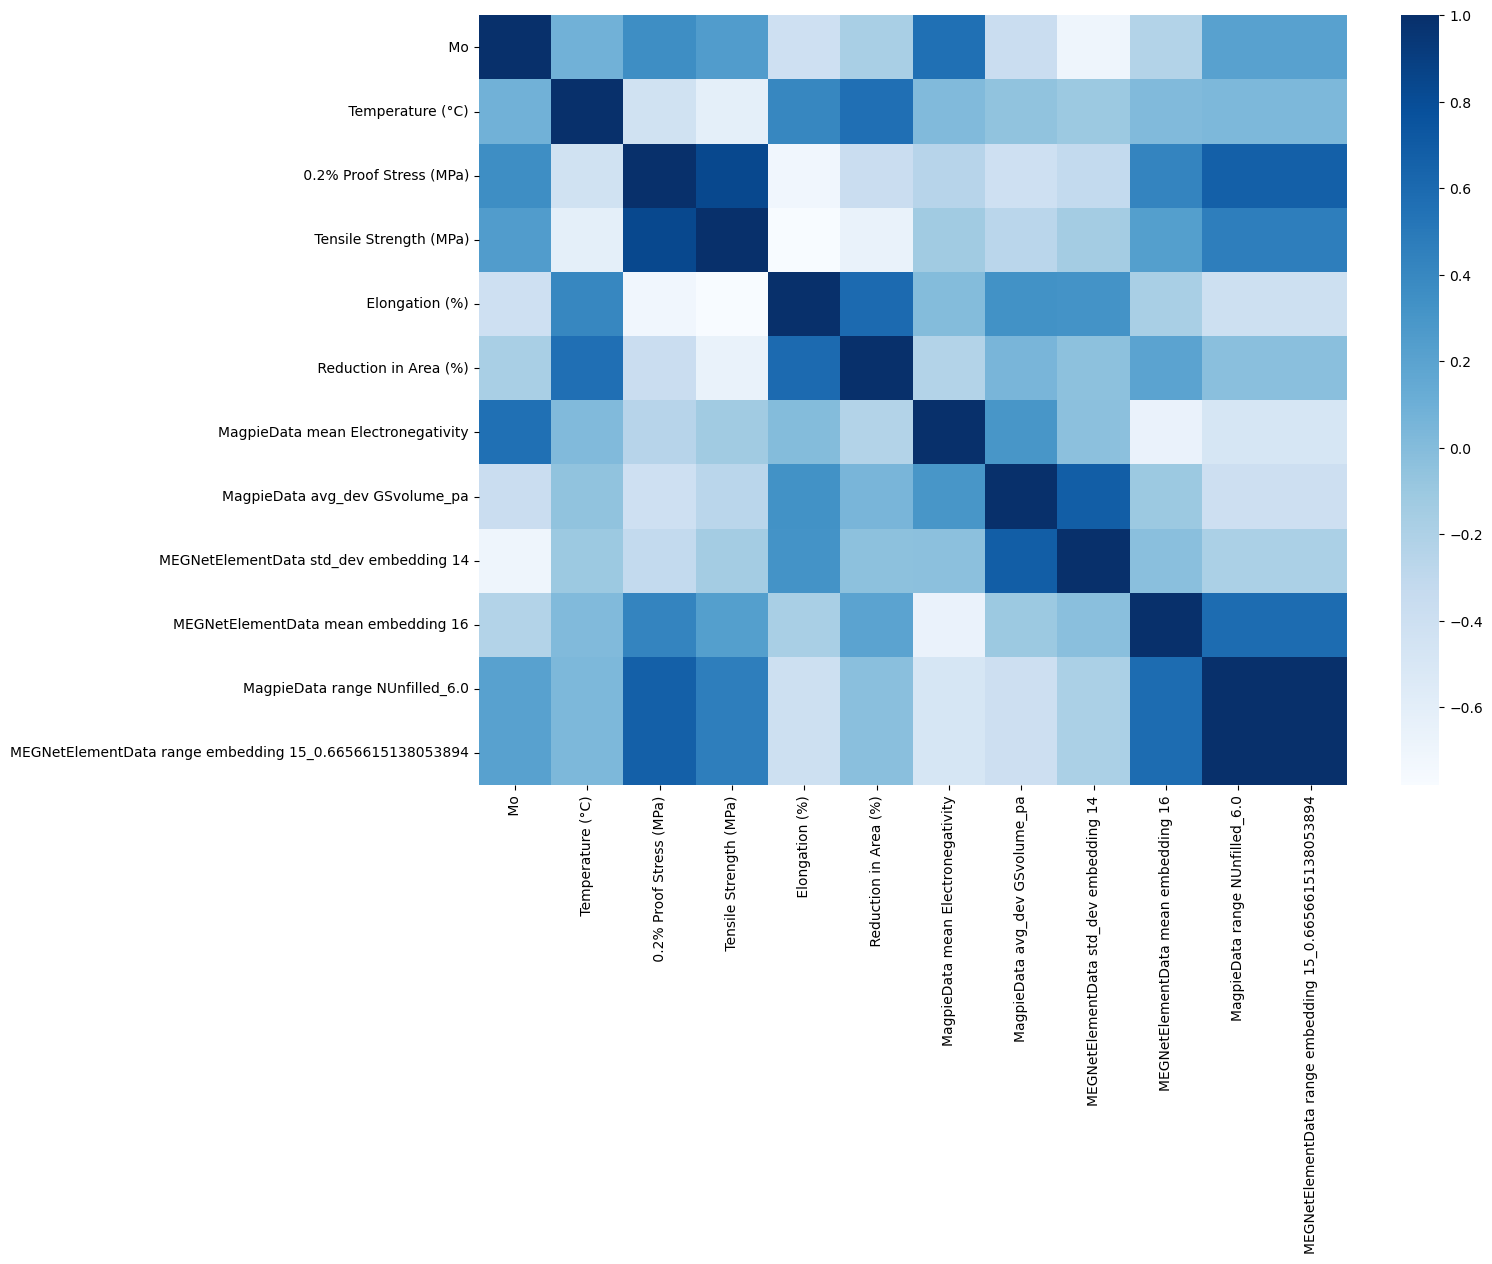

In [68]:
fig = plt.figure(figsize=(14,10))
sns.heatmap(dfs[0.5].corr(), cmap=color)

### Analysis

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('Importance Threshold')
plt.ylabel('RMSE')

plt.plot(importances[:-2], RMSE_tss[:-2], marker = 'o', c = '#5272F2', markerfacecolor = '#00A9FF', linewidth=2)
plt.plot(importances[:-2], RMSE_trs[:-2], marker = 'o', c = '#F99417', markerfacecolor = '#FFCD4B', linewidth=2)

plt.legend(['Train', 'Test'],  prop={'size':13})
plt.grid()    
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('Importance Threshold')
plt.ylabel('Execution Time, s')

plt.plot(importances[:-2], ts[:-2], marker = 'o', c = '#5D9C59', markerfacecolor = '#D2DE32', linewidth=2)

plt.grid()    
plt.show()